# Plotting predictions from models

In [29]:
import pickle
from electricity.model import TCN
import os
import argparse
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from electricity.data import ElectricityDataSet
import numpy as np
import pandas as pd
import datetime

from torch.utils.data import DataLoader

### Styles

In [30]:
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
rc("text", usetex=True)

In [31]:
model_dir = "Z:\TCN_clone\TCN\electricity\models"
model_names = [
    #"8e083e2c7751418587a58a960a7ac3fd", # scaled
    #"055ac1422aad4d0daa7d89dfa47c9e3e", # not scaled
    #"f290f6f5f28a4c4abcbd08bc972f3a61", # leveledinit scaled
    #"685b978096594f229009a3cfdca2092d", # leveledinit not scaled
    "test_clustering",
]
model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\electricity\\models\\test_clustering.pt']

In [32]:
models = []
for MODEL_PATH in model_paths:
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    print(MODEL_PATH)
    print(args)
    c_d = pickle.load(open("test_cluster_dict.pkl", "rb"))

    model = TCN(
        num_layers=args.num_layers,
        in_channels=2,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
        clustering_dict=c_d
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)

Z:\TCN_clone\TCN\electricity\models\test_clustering.pt
Namespace(N=100, bias=True, clip=True, cluster_covariate=True, cluster_dict_path='test_cluster_dict.pkl', clustering='KMeans', data_scale=True, dilated_convolutions=True, dropout=0.2, embed=None, embed_sector=False, embedding_dim=3, epochs=100, h_batch_size=256, kernel_size=7, length_rolling=24, leveledinit=False, log_interval=200, lr=0.0005, mean=0, model_save_path='electricity/models/test_clustering.pt', num_clusters=10, num_components=10, num_layers=5, num_rolling_periods=7, num_workers=4, one_hot_id=False, print=True, random_covariate=False, representation='pca', res_block_size=32, similarity='euclidean', stride=1, t=1000, tenacity=10, time_covariates=False, train_end='2014-12-16', train_start='2012-01-01', type_res_blocks='erik', v_batch_size=32, var=1.0, writer_path='electricity/runs/test_clustering', zero_covariate=False)


## Dataset - rolling val

In [33]:
ds_train = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=True,
        data_scaler=None,
        start_date="2012-01-01",  # yyyy-mm-dd
        end_date="2014-05-26",  # yyyy-mm-dd,
        cluster_dict_path="test_cluster_dict.pkl",
        cluster_covariate=True
)

Dimension of X :  torch.Size([370, 1, 21048])
Dimension of Y :  torch.Size([370, 1, 21048])


In [34]:
ds_scaled = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=True,
        data_scaler=ds_train.data_scaler,
        start_date="2014-12-08",  # yyyy-mm-dd
        end_date="2014-12-23",  # yyyy-mm-dd
        cluster_dict_path="test_cluster_dict.pkl",
        cluster_covariate=True,
        receptive_field=200
)
ds_unscaled = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=False,
        data_scaler=ds_train.data_scaler,
        start_date="2014-12-08",  # yyyy-mm-dd
        end_date="2014-12-23",  # yyyy-mm-dd
        cluster_dict_path="test_cluster_dict.pkl",
        cluster_covariate=True,
        receptive_field=200
)

Dimension of X :  torch.Size([370, 1, 384])
Dimension of Y :  torch.Size([370, 1, 384])
Dimension of X :  torch.Size([370, 1, 384])
Dimension of Y :  torch.Size([370, 1, 384])


In [35]:
dl = DataLoader(dataset=ds_scaled, batch_size=370, shuffle=False, num_workers=0)

In [36]:
iter(dl).next()[0].shape

torch.Size([370, 2, 384])

In [37]:
ids = [0,1,2, 16, 176, 316]
#model = models[0]
mods = [models[0], models[3]]
scale = [True, False]
dfs = []
for i in ids:
    d = {}
    with torch.no_grad():
        #print(ds_scaled.X[i].unsqueeze(1).shape)
        for j, model in enumerate(mods):
            if scale[j]:
                preds, _ = model.rolling_prediction(x=ds_scaled.X[i].unsqueeze(1), emb_id=i, tau=24, num_windows=7)
                predictions_rescaled = np.zeros((370, 7*24))
                predictions_rescaled[i] = preds.cpu().numpy()
                predictions_rescaled = ds_train.data_scaler.inverse_transform(predictions_rescaled.T).T
                predictions = predictions_rescaled[i]
                #d[f"model_{j}"]=predictions
                d[f"model{j}"]=preds.detach().cpu().numpy()[0]
            else:
                preds, _ = model.rolling_prediction(x=ds_unscaled.X[i].unsqueeze(1), emb_id=i, tau=24, num_windows=7)
                d[f"model{j}"]=preds.detach().cpu().numpy()[0]
        real_values = ds_unscaled.X[i, 0, -7*24 :].detach().cpu().numpy()
        d["real"] = real_values
        df = pd.DataFrame(d)
        df.index  = pd.date_range(start="2014-12-16", freq='H', periods=24*7)
        dfs.append(df)

IndexError: list index out of range

In [38]:
plot_length = 96
with plt.style.context(ts_style):
    for i in range(len(ids)): 
        ax = dfs[i][-plot_length:].plot(figsize=(2*4.77, 1.5), legend=True, color=['k', 'k'], style=['--', '-'])
        x = pd.date_range(start="2014-12-16", freq="D", periods=7)
        for xc in x:
            ax.axvline(x=xc, color='grey', linestyle='-')
        x1, x2 = ax.get_xlim()
        ax.set_xlim((x1, x2 + 1))
        ax.legend(["TCN", "TCN + leveledinit", "Target"], loc=7, frameon=False, bbox_to_anchor=(1.25, 0.5))
        plt.savefig(f"Figures\pred_id_{ids[i]}.pdf", bbox_inches="tight")

IndexError: list index out of range

In [39]:
ids = [0,1,2, 16, 176, 316]
#model = models[0]
model = models[0]
scale = [True, False]
dfs = []

x, y, idx, idx_row = iter(dl).next()
with torch.no_grad():
    print("in no grad")
    preds, _ = model.rolling_prediction(x=x, emb_id=idx_row, tau=24, num_windows=7)
    print(preds)
    predictions_rescaled = preds.cpu().numpy()
    predictions_rescaled = ds_train.data_scaler.inverse_transform(predictions_rescaled.T).T
    #predictions = predictions_rescaled[ids]
    #d[f"model_{j}"]=predictions
    for i in ids:
        d = {}
        d[f"preds{i}"]=predictions_rescaled[i]

        real_values = ds_unscaled.X[i, 0, -7*24 :]
        d["real"] = real_values
        df = pd.DataFrame(d)
        df.index  = pd.date_range(start="2014-12-16", freq='H', periods=24*7)
        dfs.append(df)

in no grad
tensor([[-4.6788e-01, -6.8189e-01, -7.7238e-01,  ...,  6.3652e-01,
          6.5479e-01,  6.3026e-01],
        [-1.4623e+00, -1.7204e+00, -1.7758e+00,  ...,  2.9882e-01,
          1.4264e-01,  5.3948e-03],
        [-2.0165e-01, -3.7618e-01, -4.7682e-01,  ...,  8.0097e-01,
          8.5076e-01,  8.3771e-01],
        ...,
        [ 1.5638e+00,  4.4416e-01, -2.5827e-01,  ...,  1.6665e+00,
          1.8864e+00,  1.6457e+00],
        [-9.9408e-01, -1.0910e+00, -1.0651e+00,  ...,  4.5543e-01,
          4.5322e-01,  4.1155e-01],
        [ 4.8189e-01,  5.3388e-01,  4.6979e-01,  ..., -4.9335e+00,
         -5.6010e+00, -6.0339e+00]])


[                        preds0     real
2014-12-16 00:00:00  10.429401  10.1520
2014-12-16 01:00:00   5.274566  11.4210
2014-12-16 02:00:00   3.094864  11.4210
2014-12-16 03:00:00   8.777707  10.1520
2014-12-16 04:00:00  18.739525  11.4210
...                        ...      ...
2014-12-22 19:00:00  35.312244   8.8832
2014-12-22 20:00:00  34.984646   8.8832
2014-12-22 21:00:00  37.031723  10.1520
2014-12-22 22:00:00  37.471691  10.1520
2014-12-22 23:00:00  36.880966   8.8832

[168 rows x 2 columns],                          preds1        real
2014-12-16 00:00:00   72.538414   73.257004
2014-12-16 01:00:00   65.777016   68.278999
2014-12-16 02:00:00   64.325043   66.144997
2014-12-16 03:00:00   70.715256   65.433998
2014-12-16 04:00:00   79.121201   67.568001
...                         ...         ...
2014-12-22 19:00:00  121.908234   98.151001
2014-12-22 20:00:00  122.499565  101.709999
2014-12-22 21:00:00  118.677933   94.595001
2014-12-22 22:00:00  114.586128   90.327003
2014-12-22

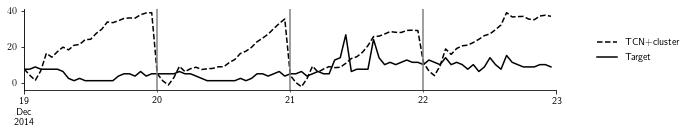

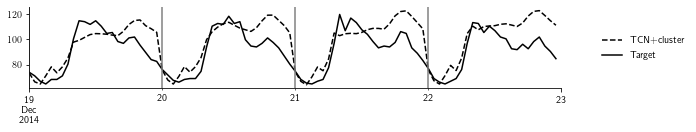

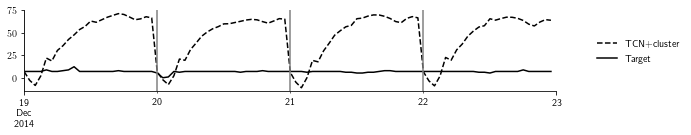

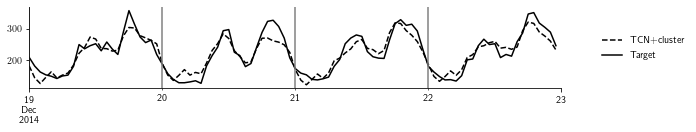

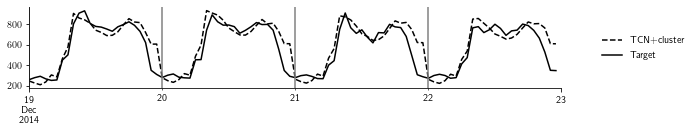

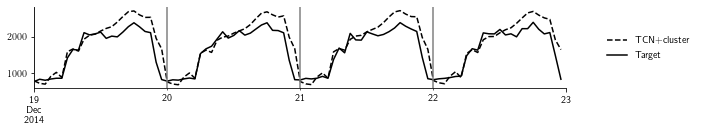

In [40]:
plot_length = 96
with plt.style.context(ts_style):
    for i in range(len(ids)):
        #print(dfs)
        ax = dfs[i][-plot_length:].plot(figsize=(2*4.77, 1.5), legend=True, color=['k', 'k'], style=['--', '-'])
        x = pd.date_range(start="2014-12-16", freq="D", periods=7)
        for xc in x:
            ax.axvline(x=xc, color='grey', linestyle='-')
        x1, x2 = ax.get_xlim()
        ax.set_xlim((x1, x2 + 1))
        ax.legend(["TCN+cluster", "Target"], loc=7, frameon=False, bbox_to_anchor=(1.25, 0.5))
        plt.savefig(f"Figures\pred_id_{ids[i]}.pdf", bbox_inches="tight")

# Plot representation from models

In [41]:
model_dir = "Z:\TCN_clone\TCN\electricity\models"
model_names = [
    "e94106c6db6e44c88e497fe5062c0afd",
    "ce17bfb7d3594816a20faa55795a8084",
    "d48d5f0d9bb04edda06f7e3a532b1370",
    "192a0d0d02d146dfb3148b7af4e10c19",
    "0e61357a42ee434abd1c5fe170f3f2f4",
    "ee140872041044898f7cd02412975459",
    "b0dccaa25461401bb7c8e4daade97c79",
    "81f27dc04c334908a01ec85f6671ef17"
]
model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\electricity\\models\\e94106c6db6e44c88e497fe5062c0afd.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\ce17bfb7d3594816a20faa55795a8084.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\d48d5f0d9bb04edda06f7e3a532b1370.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\192a0d0d02d146dfb3148b7af4e10c19.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\0e61357a42ee434abd1c5fe170f3f2f4.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\ee140872041044898f7cd02412975459.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\b0dccaa25461401bb7c8e4daade97c79.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\81f27dc04c334908a01ec85f6671ef17.pt']

In [42]:
models = []
for MODEL_PATH in model_paths:
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    model = TCN(
        num_layers=args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)
#print(models)

## Embedding layer of each model

In [43]:
embeddings = []
for model in models:
    ids = [i for i in range(370)]
    ids = torch.LongTensor(ids).to("cpu")
    embds = model.embedding(ids).detach().cpu().numpy()
    embeddings.append(embds)

## Visualize

In [44]:
mystyle = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}

In [45]:
with plt.style.context(mystyle):
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        if embedding.shape[1] > 2:
            tsne = TSNE(n_components=2)
            embedding = tsne.fit_transform(embedding)
        #plt.figure()
        #plt.scatter(embedding[:,0], embedding[:,1], c="#00B0F0", edgecolor="black", linewidth=0.5)
        #plt.title(f"Embedding dim {nc}")
        #plt.show()
#"colors = ["#FFC000", "#00B0F0"]ø

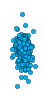

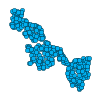

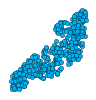

In [46]:
size=4.77/3
with plt.style.context(mystyle):
    plt.figure(figsize=(size, size))
    plt.scatter(embeddings[0][:,0], embeddings[0][:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.axis('scaled')
    #plt.title(f"Embedding dim {nc}")
    plt.savefig("electricity_learned_embedding_2.pdf")#, bbox_inches="tight")
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(embedding)
        plt.figure(figsize=(size, size))
        plt.scatter(embedding[:,0], embedding[:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.axis('scaled')
        #plt.title(f"Embedding dim {nc}")
        plt.savefig(f"electricity_learned_embedding_{nc}_tsne.pdf")#, bbox_inches="tight")

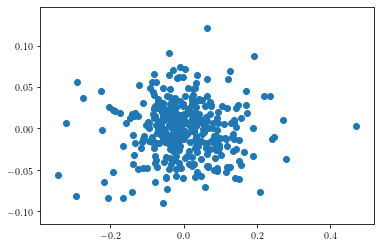

In [47]:
from sklearn.decomposition import PCA
pca = PCA(2)
embds = pca.fit_transform(embeddings[1])
plt.scatter(embds[:,0], embds[:,1])

In [48]:
s = """
e94106c6db6e44c88e497fe5062c0afd
ce17bfb7d3594816a20faa55795a8084
d48d5f0d9bb04edda06f7e3a532b1370
192a0d0d02d146dfb3148b7af4e10c19
0e61357a42ee434abd1c5fe170f3f2f4
ee140872041044898f7cd02412975459
b0dccaa25461401bb7c8e4daade97c79
81f27dc04c334908a01ec85f6671ef17
"""
s.replace("\n", "\",\"")

'","e94106c6db6e44c88e497fe5062c0afd","ce17bfb7d3594816a20faa55795a8084","d48d5f0d9bb04edda06f7e3a532b1370","192a0d0d02d146dfb3148b7af4e10c19","0e61357a42ee434abd1c5fe170f3f2f4","ee140872041044898f7cd02412975459","b0dccaa25461401bb7c8e4daade97c79","81f27dc04c334908a01ec85f6671ef17","'